In [1]:
%matplotlib notebook
import matplotlib as mpl
import pandas as pd
import sys
sys.path.append('../libs')
mpl.style.use('ggplot')
import matplotlib.pyplot as plt
from os.path import isfile,exists
import math
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import time
import pickle
from functools import reduce

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical, normalize
from keras.preprocessing import  sequence
import tensorflow as tf

from keras.models import Sequential, Model
from keras import regularizers
from keras.layers import Dropout, Input, Conv1D, MaxPool1D,GlobalMaxPooling1D, Lambda
from libs import evt as evtlib
import requests
from collections import defaultdict
import ujson
from trainer.model import transform, fit_training_data, normalize, MAX_LEN
from functools import reduce

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_x, test_x = ujson.load(open('../motion_data/train.json')),ujson.load(open('../motion_data/eval.json'))
train_x, test_x = np.array(train_x), np.array(test_x)

In [3]:
def compile_model(model):
    model.compile(optimizer='adadelta', loss='mse',metrics=['accuracy'])
    return model


def model_fn(input_shape, hidden_dim):
    input_layer = Input(shape=input_shape)
    encoded = Conv1D(hidden_dim,1,activation='tanh')(input_layer)
    encoded = Conv1D(hidden_dim,1,activation='relu')(encoded)
    decoded = Conv1D(input_shape[-1],1,activation='relu')(encoded)
    return compile_model(Model(inputs=input_layer, outputs=decoded))

In [4]:
model = model_fn(train_x.shape[1:], 20)
history = model.fit(train_x, train_x, epochs=100, batch_size=4,shuffle=True, validation_split=0.2,verbose=0)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [5]:
model.evaluate(test_x, test_x)



174/174 [==============================] - 0s 65us/step


[0.025555503693805343, 0.1973180078055667]

<IPython.core.display.Javascript object>


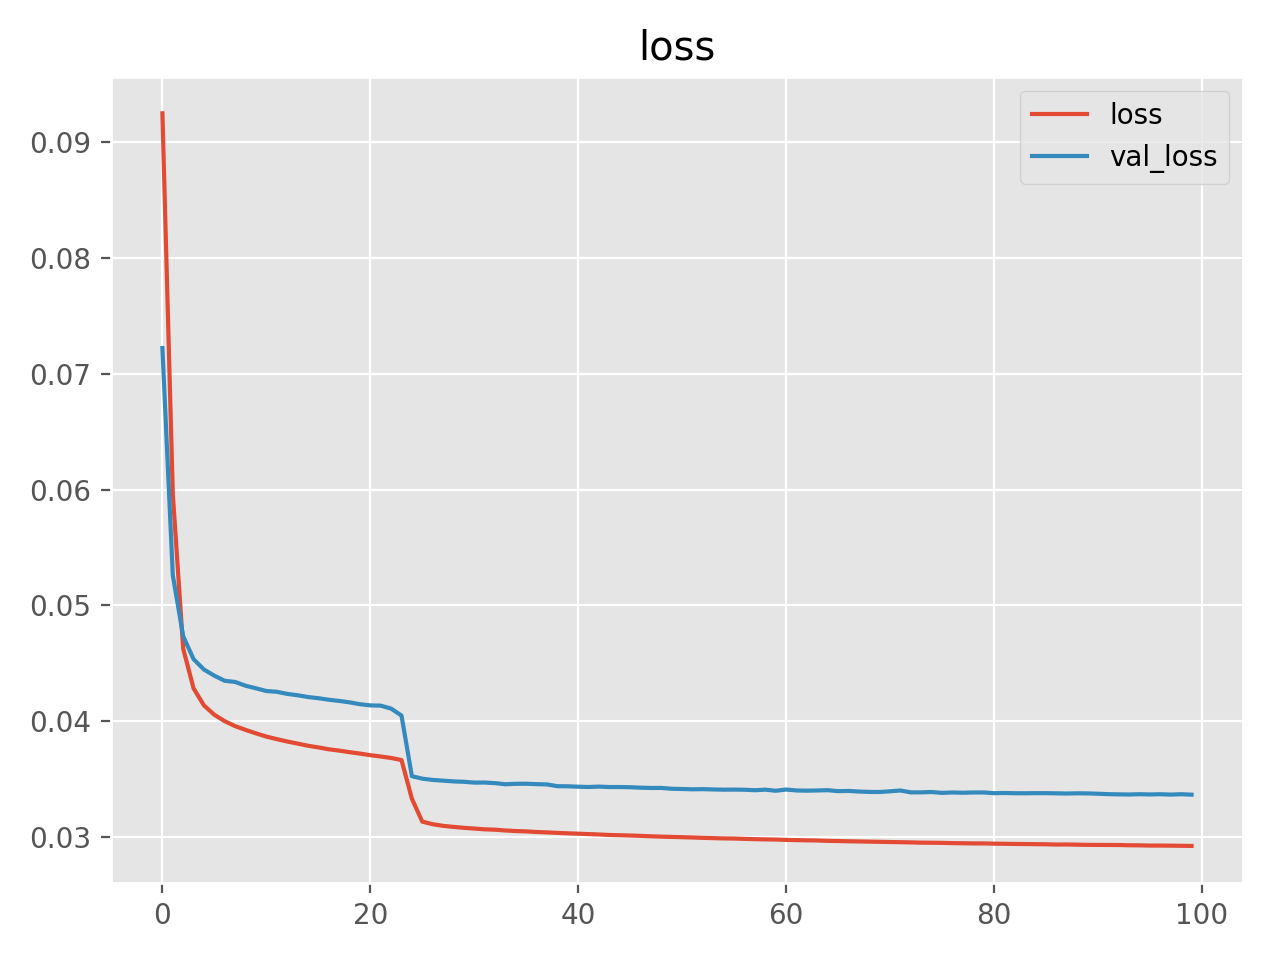

In [6]:
pd.DataFrame(
    dict(
        map(lambda x: (x,history.history[x]),
            filter(lambda x: 'acc'not in x,history.history)))).plot(title='loss')
plt.tight_layout()

0.0

In [7]:
data = [[i['value'] for i in d] for d in ujson.load(open('../motion_data/rawdata.json')).values()]

In [8]:
data = reduce(lambda x,y:x+y, data)

In [9]:
np.vstack(data)[:,1:]

array([[-0.02941895, -0.00134277,  0.9782715 ],
       [ 0.05432129,  0.08093262,  0.9610596 ],
       [ 0.09313965,  0.1546631 ,  0.9240723 ],
       ...,
       [-0.1525879 ,  0.1853027 ,  0.8758545 ],
       [-0.0078125 , -0.00427246,  1.028198  ],
       [-0.05456543,  0.02258301,  0.9855957 ]])

In [10]:
_max = np.vstack(data)[:,1:].max(axis=0)
_min = np.vstack(data)[:,1:].min(axis=0)

In [11]:
(np.array(data[0])[:,1:] - _min)/(_max-_min)

array([[0.49650405, 0.49964886, 0.62216046],
       [0.50697669, 0.5099383 , 0.62000792],
       [0.51183136, 0.51915912, 0.61538225],
       [0.5104574 , 0.52677697, 0.62321382],
       [0.50586226, 0.51990716, 0.62289324],
       [0.50647291, 0.51674705, 0.61513798],
       [0.500687  , 0.5199377 , 0.6241756 ],
       [0.49372559, 0.51004517, 0.62252685],
       [0.48482538, 0.50683926, 0.62699988],
       [0.49963363, 0.50755677, 0.62225205],
       [0.49847339, 0.506366  , 0.62765633],
       [0.49906878, 0.50442719, 0.62180934],
       [0.50129765, 0.50108388, 0.62280163],
       [0.49952677, 0.50300743, 0.64357898],
       [0.49926724, 0.50719038, 0.62162613]])

In [18]:
train_x.shape

(406, 3, 40)